# **Automatic User Engagement Assessment from The Robotic Point of View**

In [25]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tqdm import tqdm

# **DATA PREPARATION AND PREPROCESSING (VIDEO FRAMES AND ENGAGMENT ANNOTATION DATA)**

In [1]:

import os
import imageio
import cv2
from IPython.display import Image


def crop_and_extract_frames(video_path, output_dir, start_time=0, end_time=None, target_size=(320, 240)):
    os.makedirs(output_dir, exist_ok=True)

    # Open the video
    cap = cv2.VideoCapture(video_path)

    # Get the video dimensions
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Determine the region of interest (ROI) for the actual video
    # Adjust the values based on your specific screen recording
    x, y, w, h = 250, 100, 1200, 500
    # x, y, w, h = 400, 300, 1200, 600

    fps = cap.get(cv2.CAP_PROP_FPS)

    start_frame = int(start_time * fps)
    if end_time is not None:
        end_frame = int(end_time * fps)
    else:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count >= start_frame:
            # Crop the frame to the ROI
            cropped_frame = frame[y:y+h, x:x+w]

            # Resize the cropped frame to the target size
            resized_frame = cv2.resize(cropped_frame, target_size, interpolation=cv2.INTER_AREA)
            frame_path = os.path.join(output_dir, f"frame_{frame_count}.png")
            cv2.imwrite(frame_path, resized_frame)

        frame_count += 1
        if frame_count >= end_frame:
            break

    cap.release()

    # Play the extracted frames
    frames = [imageio.imread(os.path.join(output_dir, f)) for f in os.listdir(output_dir)]
    imageio.mimsave('output.gif', frames, duration=1/fps)
    display(Image(url='output.gif'))

    # # Delete all extracted frames
    # for file in os.listdir(output_dir):
    #     os.remove(os.path.join(output_dir, file))

# Usage
video_path = '/content/drive/MyDrive/hri/hri_video.mp4'
output_dir = '/content/drive/MyDrive/hri/output'
start_time = 5
end_time = 60
target_size = (320, 240)  # Adjust the target size as per your requirements

crop_and_extract_frames(video_path, output_dir, start_time, end_time, target_size)

<ipython-input-1-10d6566b518f>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(os.path.join(output_dir, f)) for f in os.listdir(output_dir)]


In [26]:
engagement_data = pd.read_csv('/content/drive/MyDrive/hri/fd.csv')
engagement_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3478 entries, 0 to 3477
Data columns (total 78 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   experiment_id_x            3478 non-null   int64  
 1   session_id_x               3478 non-null   int64  
 2   device_id_x                3478 non-null   int64  
 3   event_id_x                 3478 non-null   int64  
 4   type_x                     3478 non-null   int64  
 5   device_time_x              3478 non-null   int64  
 6   logged_time_x              3478 non-null   float64
 7   time_x                     3478 non-null   float64
 8   confidence_interval_x      3478 non-null   int64  
 9   delay_x                    3478 non-null   float64
 10  filter_id_x                3478 non-null   int64  
 11  left_gaze_x                3478 non-null   float64
 12  left_gaze_y                3478 non-null   float64
 13  left_gaze_z                3478 non-null   int64

# **IMAGE ANNOTATION FOR ENGAGEMENT CLUSTERS AND MODELLING**

In [3]:


# Step 1: Load and preprocess image data (optimized)
def load_images(folder_path, max_images=None):
    images = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.png'):
            if max_images and i >= max_images:
                break
            img_path = os.path.join(folder_path, filename)
            img = np.array(Image.open(img_path).resize((224, 224)))  # Resize immediately
            images.append(img)
    return np.array(images)

# Step 2: Load CSV file (optimized)
def load_csv_data(csv_path, max_rows=None):
    return pd.read_csv(csv_path, nrows=max_rows)

# Step 3: Create heatmaps for each engagement class (optimized)
def create_heatmaps(csv_data, image_shape):
    h, w = image_shape[:2]
    heatmaps = np.zeros((len(csv_data), h, w), dtype=np.float32)

    for i, row in tqdm(csv_data.iterrows(), total=len(csv_data)):
        gaze_x = (row['left_gaze_x'] + row['right_gaze_x']) / 2
        gaze_y = (row['left_gaze_y'] + row['right_gaze_y']) / 2

        gaze_x = max(0, min(int(gaze_x * w), w - 1))
        gaze_y = max(0, min(int(gaze_y * h), h - 1))

        heatmaps[i, gaze_y, gaze_x] = 1
        heatmaps[i] = cv2.GaussianBlur(heatmaps[i], (15, 15), 0)

    return heatmaps

# Step 4: Classify images using existing engagement cluster
def classify_images(csv_data):
    clusters = csv_data['engagement_cluster'].values
    print("Unique engagement clusters:", np.unique(clusters))
    return clusters

# Step 5: Organize classified images into folders (removed to save memory)

# Step 6: Prepare data for ResNet modeling (modified)
def prepare_resnet_data(images, classifications):
    return images, classifications

# Main execution
if __name__ == "__main__":
    max_samples = 1000  # Adjust this based on your available RAM

    # Load data
    images = load_images('/content/drive/MyDrive/hri/output', max_images=max_samples)
    csv_data = load_csv_data('/content/drive/MyDrive/hri/fd.csv', max_rows=max_samples)

    print(f"Number of images: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"CSV data shape: {csv_data.shape}")
    print(f"Sample row from CSV:\n{csv_data.iloc[0]}")

    # Create heatmaps
    heatmaps = create_heatmaps(csv_data, images[0].shape)

    # Classify images
    classifications = classify_images(csv_data)

    # Prepare data for ResNet
    X, y = prepare_resnet_data(images, classifications)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create ResNet model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile and train the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    print("Processing complete. ResNet model trained on classified images.")

Number of images: 1000
Image shape: (224, 224, 3)
CSV data shape: (1000, 78)
Sample row from CSV:
experiment_id_x                 1
session_id_x                    1
device_id_x                     0
event_id_x                     10
type_x                         10
                           ...   
window_id                      10
gaze_cursor_distance     1.474309
gaze_velocity                 0.0
time_since_last_click         0.0
engagement_cluster              1
Name: 0, Length: 78, dtype: object


100%|██████████| 1000/1000 [00:00<00:00, 2819.60it/s]


Unique engagement clusters: [0 1 2]
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 572ms/step - accuracy: 0.5182 - loss: 2.0099 - val_accuracy: 0.5400 - val_loss: 48621.0898
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 276ms/step - accuracy: 0.7716 - loss: 0.5749 - val_accuracy: 0.2150 - val_loss: 3625.0054
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.7712 - loss: 0.5831 - val_accuracy: 0.5400 - val_loss: 43.9928
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.8020 - loss: 0.4979 - val_accuracy: 0.5450 - val_loss: 36.3788
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.8046 - loss: 0.4594 - val_accuracy: 0.1950 - val_loss: 10.4864
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.8676 - loss: 0.4452 - val_accuracy: 0.7900 - val_loss: 1.2920
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.9024 - loss: 0.2585 - val_accuracy: 0.7150 - val_loss: 2.3168


# **IMAGE CLASSIFICATION FOR ENGAGEMENT LEVEL (TRAINING AND EVALUATION)**

Number of images: 1000
Image shape: (224, 224, 3)
CSV data shape: (1000, 78)
Sample row from CSV:
experiment_id_x                 1
session_id_x                    1
device_id_x                     0
event_id_x                     10
type_x                         10
                           ...   
window_id                      10
gaze_cursor_distance     1.474309
gaze_velocity                 0.0
time_since_last_click         0.0
engagement_cluster              1
Name: 0, Length: 78, dtype: object


100%|██████████| 1000/1000 [00:00<00:00, 1149.60it/s]


Unique engagement clusters: [0 1 2]
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 575ms/step - accuracy: 0.5781 - loss: 1.8682 - val_accuracy: 0.5400 - val_loss: 48.7823
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 296ms/step - accuracy: 0.7457 - loss: 0.5495 - val_accuracy: 0.5400 - val_loss: 35.9184
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.8083 - loss: 0.4053 - val_accuracy: 0.5400 - val_loss: 662.0403
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.8343 - loss: 0.3678 - val_accuracy: 0.7700 - val_loss: 1.7625
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.8659 - loss: 0.3111 - val_accuracy: 0.5400 - val_loss: 639.9637
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.8846 - loss: 0.2675 - val_accuracy: 0.7300 - val_loss: 0.7229
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.8784 - loss: 0.2853 - val_accuracy: 0.8050 - val_loss: 0.4922
Epoc

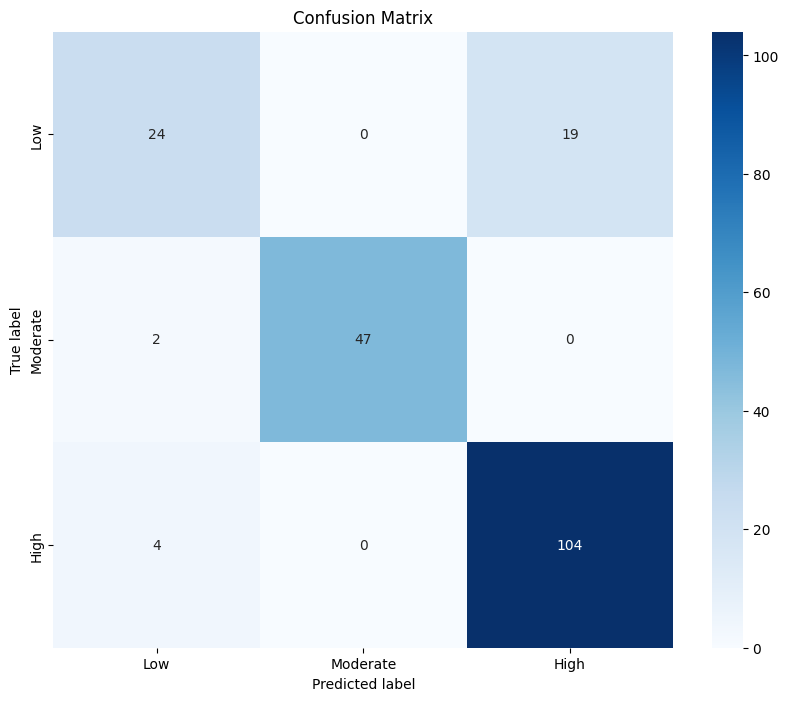

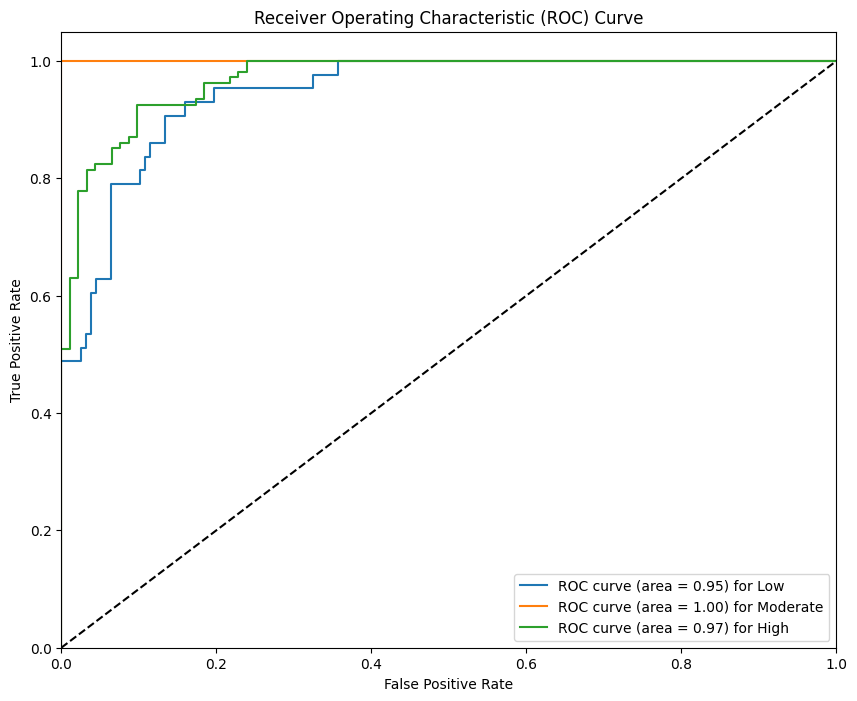

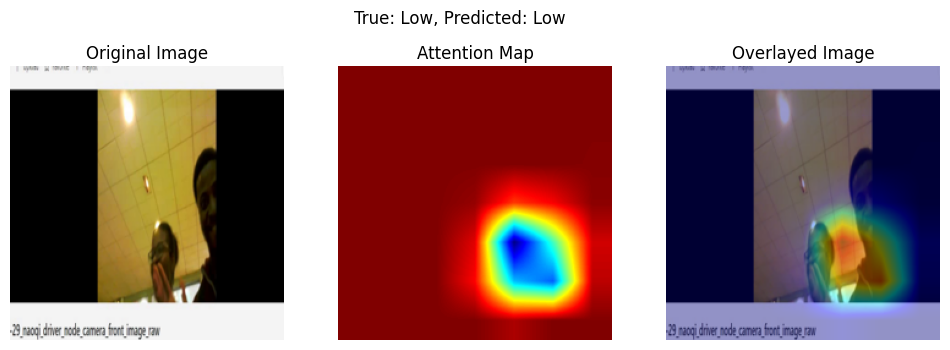

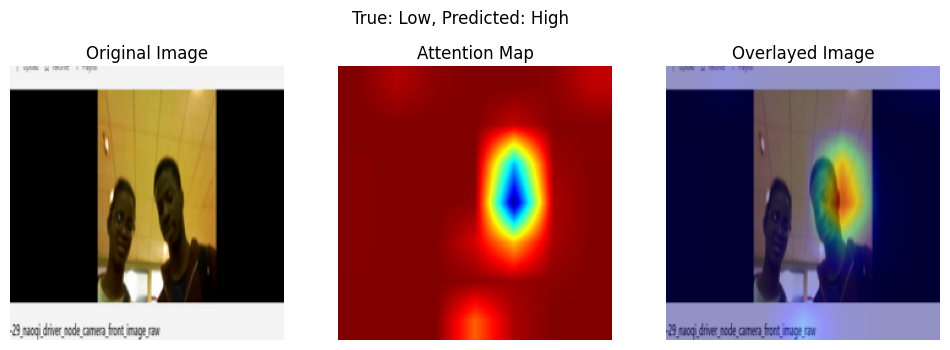

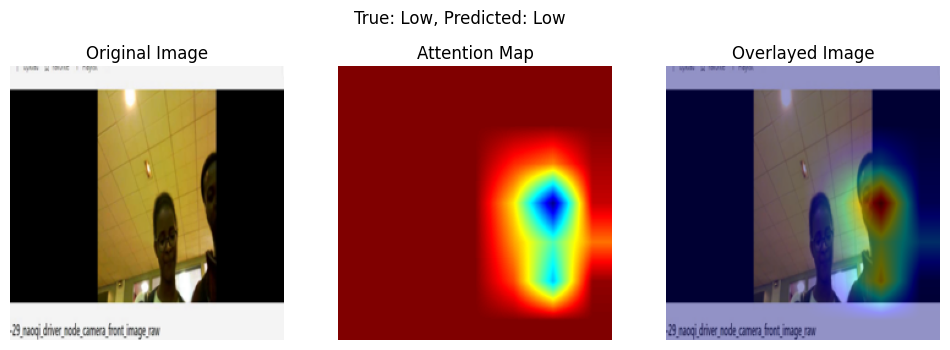

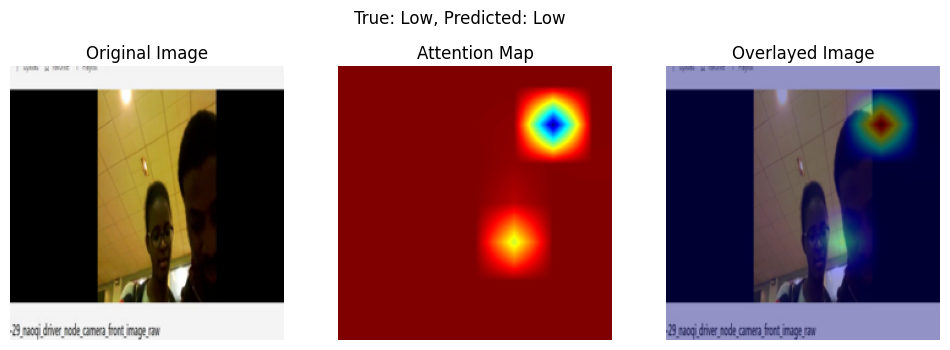

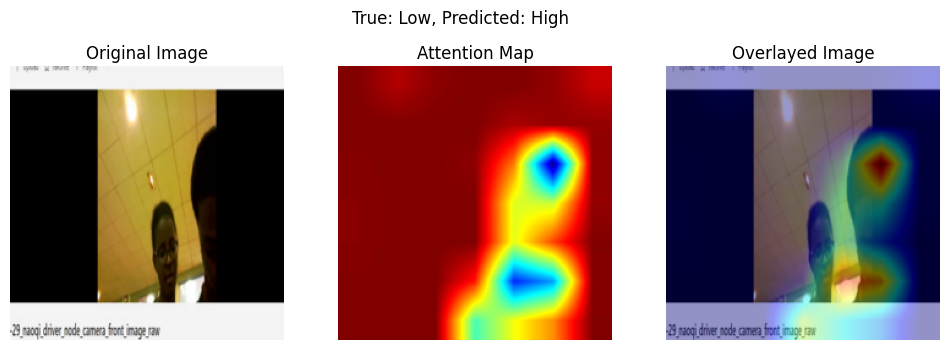

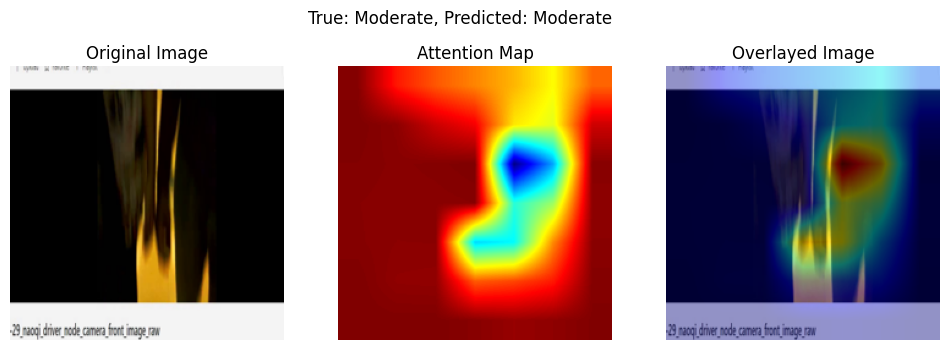

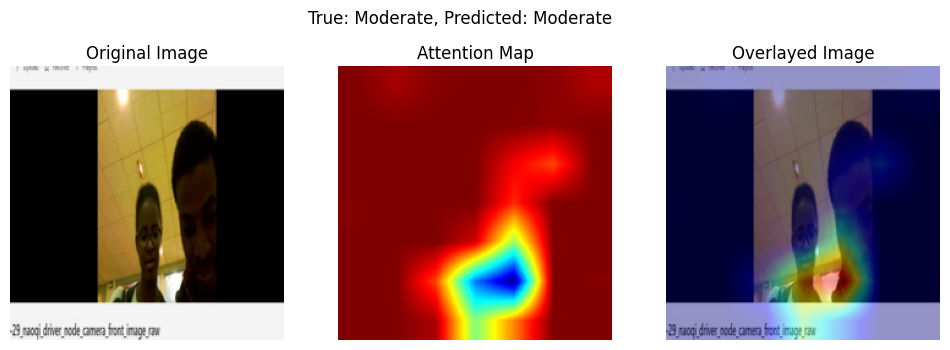

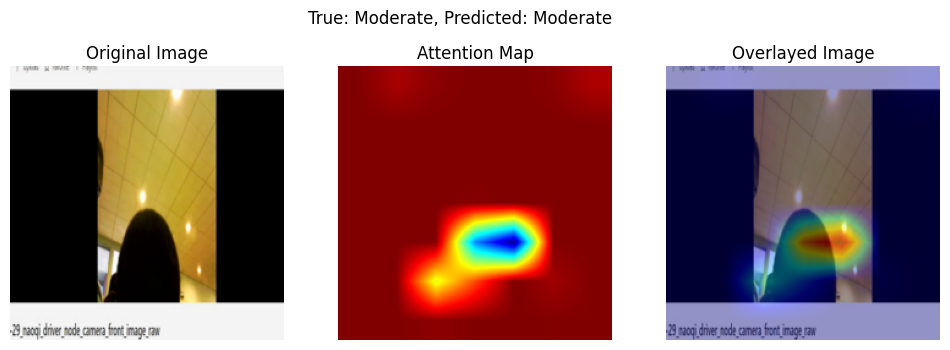

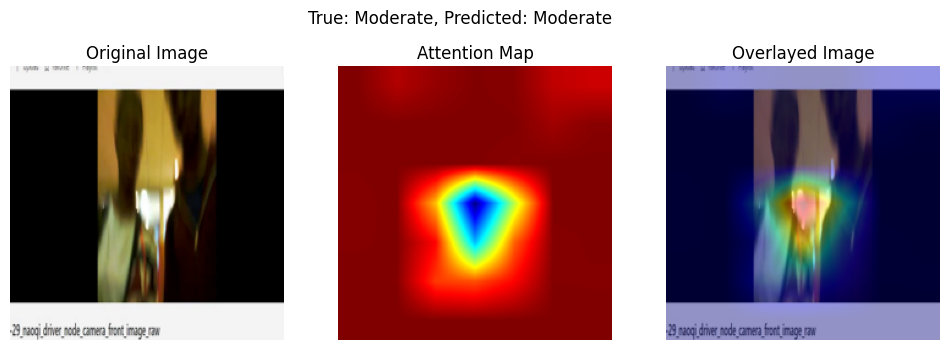

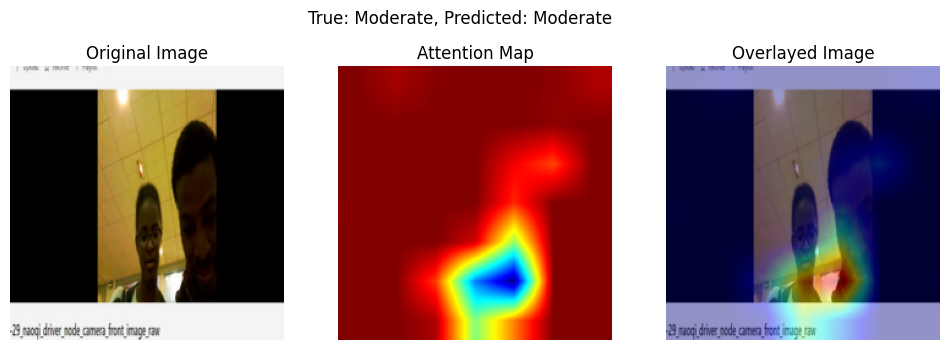

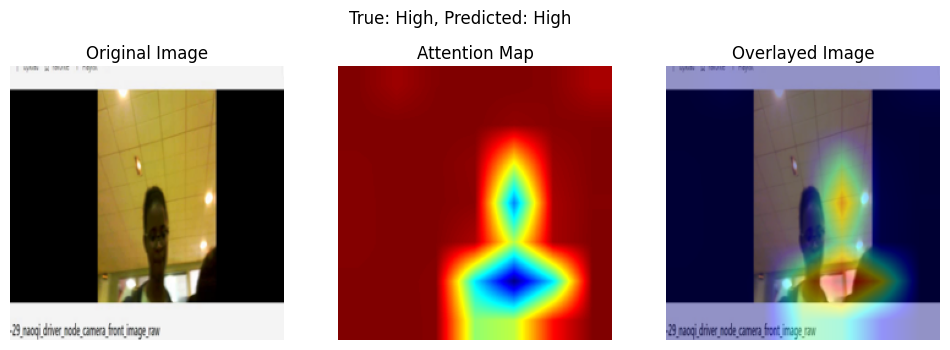

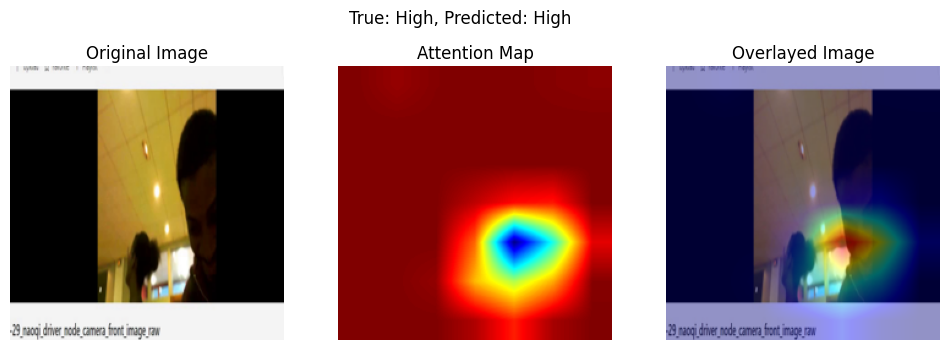

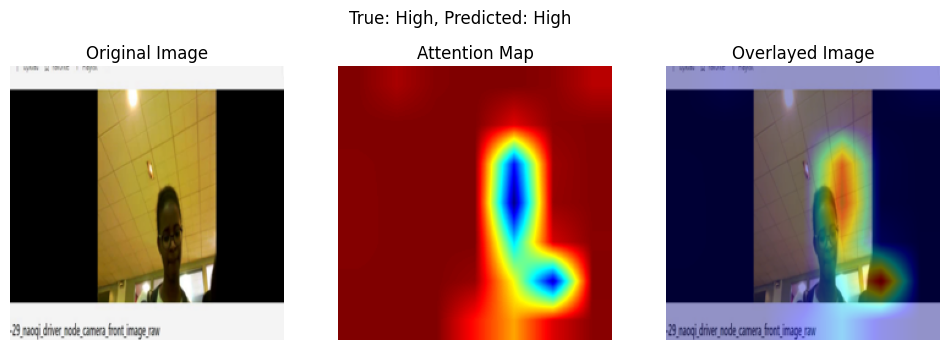

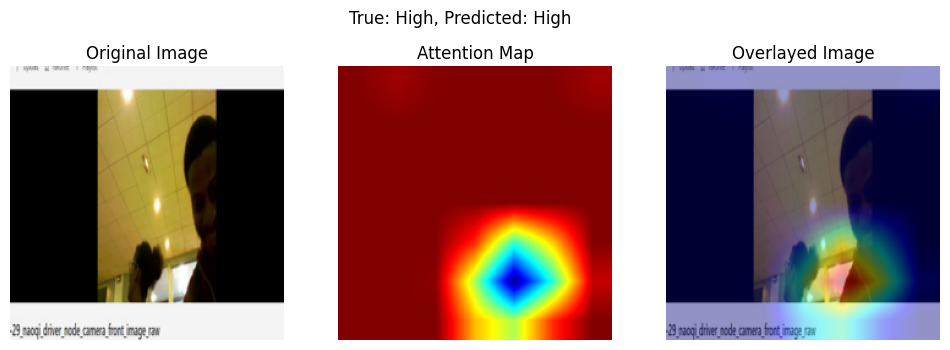

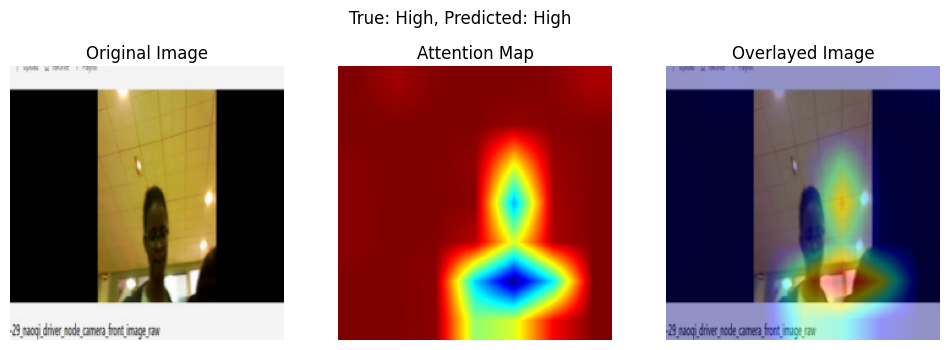

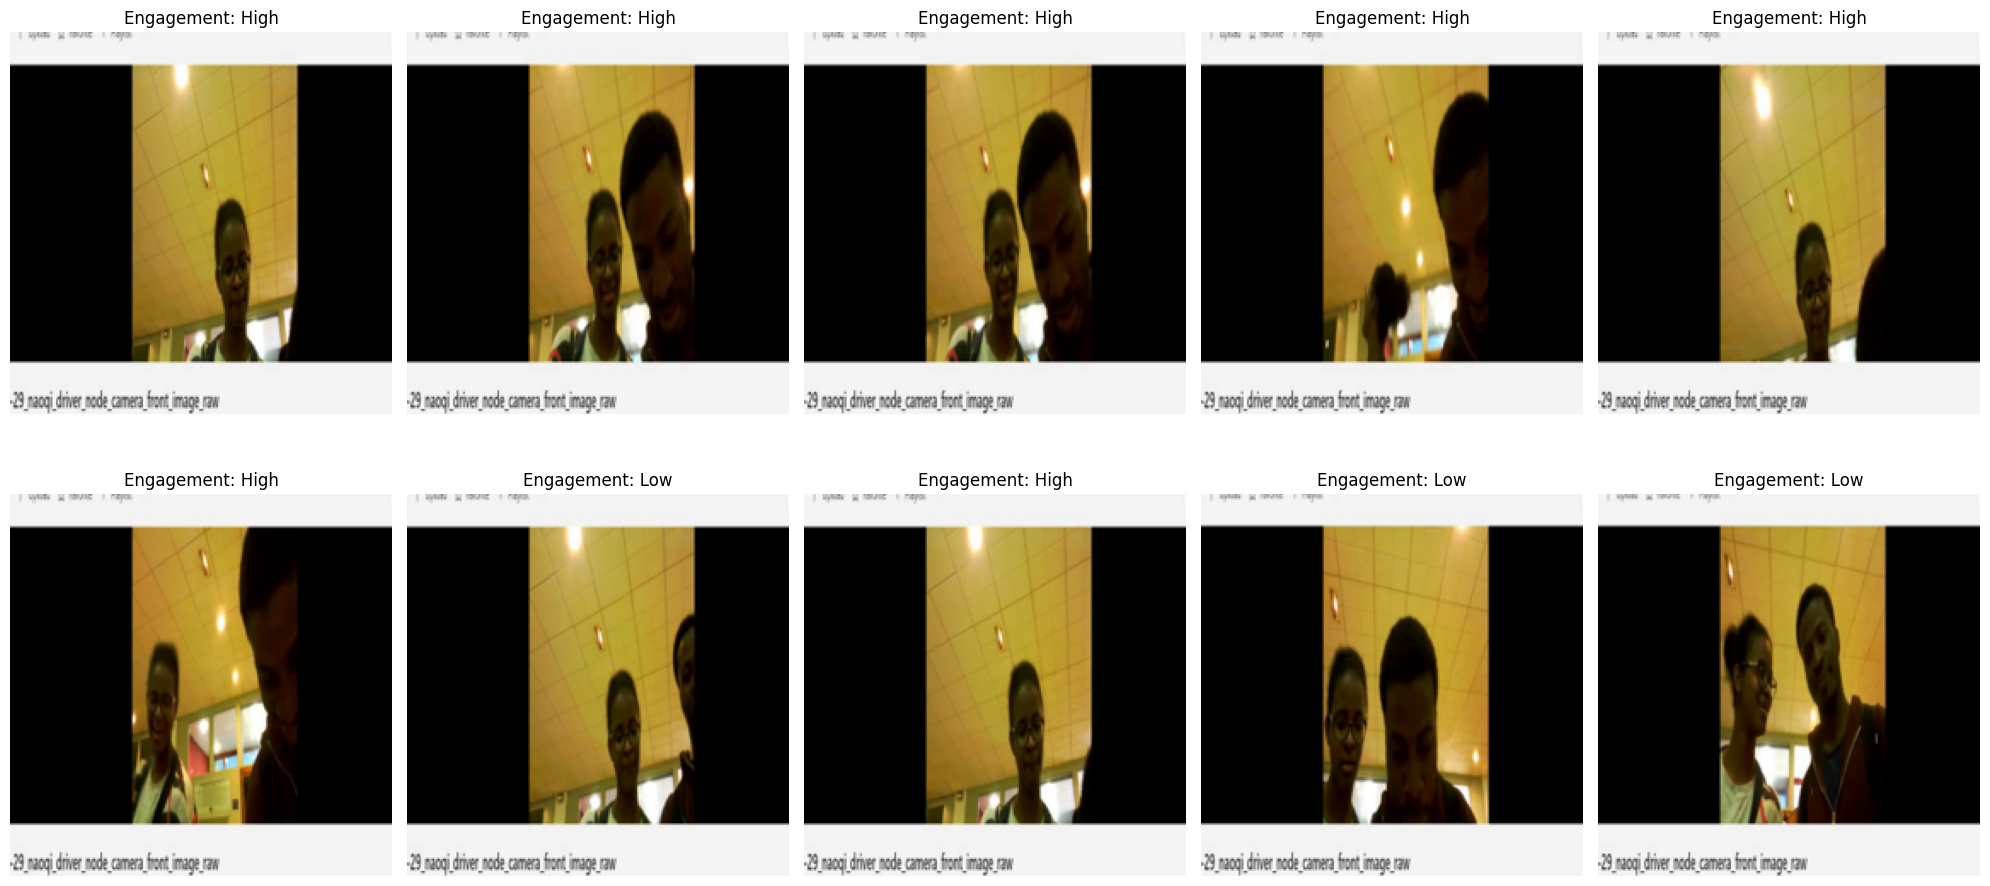

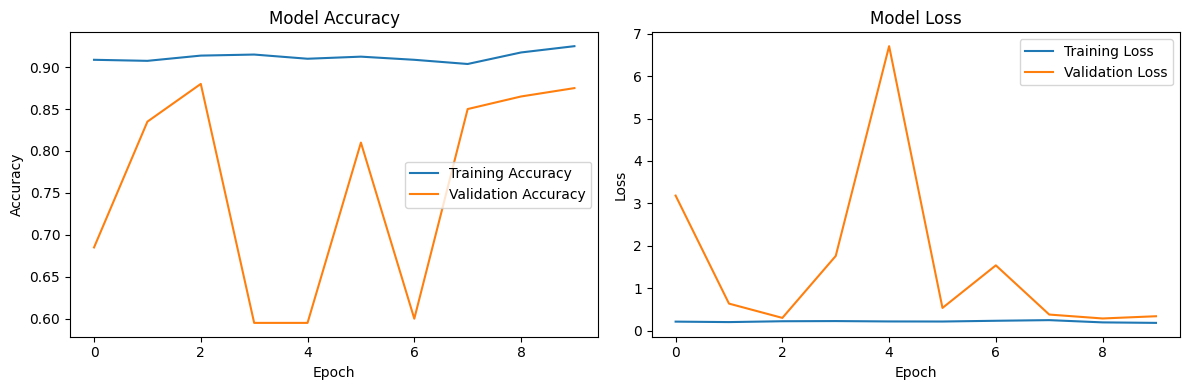

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Step 1: Load and preprocess image data (optimized)
def load_images(folder_path, max_images=None):
    images = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.png'):
            if max_images and i >= max_images:
                break
            img_path = os.path.join(folder_path, filename)
            img = np.array(Image.open(img_path).resize((224, 224)))  # Resize immediately
            images.append(img)
    return np.array(images)

# Step 2: Load CSV file (optimized)
def load_csv_data(csv_path, max_rows=None):
    return pd.read_csv(csv_path, nrows=max_rows)

# Step 3: Create heatmaps for each engagement class (optimized)
def create_heatmaps(csv_data, image_shape):
    h, w = image_shape[:2]
    heatmaps = np.zeros((len(csv_data), h, w), dtype=np.float32)

    for i, row in tqdm(csv_data.iterrows(), total=len(csv_data)):
        gaze_x = (row['left_gaze_x'] + row['right_gaze_x']) / 2
        gaze_y = (row['left_gaze_y'] + row['right_gaze_y']) / 2

        gaze_x = max(0, min(int(gaze_x * w), w - 1))
        gaze_y = max(0, min(int(gaze_y * h), h - 1))

        heatmaps[i, gaze_y, gaze_x] = 1
        heatmaps[i] = cv2.GaussianBlur(heatmaps[i], (15, 15), 0)

    return heatmaps

# Step 4: Classify images using existing engagement cluster
def classify_images(csv_data):
    clusters = csv_data['engagement_cluster'].values
    print("Unique engagement clusters:", np.unique(clusters))
    return clusters

# Step 5: Organize classified images into folders (removed to save memory)

# Step 6: Prepare data for ResNet modeling (modified)
def prepare_resnet_data(images, classifications):
    return images, classifications

# Main execution
if __name__ == "__main__":
    max_samples = 1000  # Adjust this based on your available RAM

    # Load data
    images = load_images('/content/drive/MyDrive/hri/output', max_images=max_samples)
    csv_data = load_csv_data('/content/drive/MyDrive/hri/fd.csv', max_rows=max_samples)

    print(f"Number of images: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"CSV data shape: {csv_data.shape}")
    print(f"Sample row from CSV:\n{csv_data.iloc[0]}")

    # Create heatmaps
    heatmaps = create_heatmaps(csv_data, images[0].shape)

    # Classify images
    classifications = classify_images(csv_data)

    # Prepare data for ResNet
    X, y = prepare_resnet_data(images, classifications)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create ResNet model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile and train the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    # Compile and train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


    print("Processing complete. ResNet model trained on classified images.")

# After model training, add these evaluation and visualization functions:

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, classes):
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {classes[i]}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def visualize_attention_maps(model, X_test, y_test, classes, num_images=5):
    # Create a model that outputs both the final predictions and the last convolutional layer
    last_conv_layer = model.get_layer('conv5_block3_out')
    attention_model = Model(inputs=model.inputs, outputs=[model.output, last_conv_layer.output])

    for class_idx in range(len(classes)):
        class_indices = np.where(y_test == class_idx)[0]
        np.random.shuffle(class_indices)
        selected_indices = class_indices[:num_images]

        for idx in selected_indices:
            img = X_test[idx]
            img_expanded = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)

            # Get model predictions and feature maps
            with tf.GradientTape() as tape:
                preds, features = attention_model(img_expanded)
                predicted_class = tf.argmax(preds[0])
                class_output = preds[:, predicted_class]

            # Calculate gradients
            grads = tape.gradient(class_output, features)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

            # Calculate attention map
            attention_map = tf.reduce_sum(tf.multiply(pooled_grads, features[0]), axis=-1)
            attention_map = tf.maximum(attention_map, 0) / tf.math.reduce_max(attention_map)
            attention_map = attention_map.numpy()

            # Resize and overlay attention map on original image
            attention_map = cv2.resize(attention_map, (img.shape[1], img.shape[0]))
            attention_map = np.uint8(255 * attention_map)
            attention_map = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
            overlayed_img = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, attention_map, 0.4, 0)

            # Display original image and attention map
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(attention_map)
            plt.title('Attention Map')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
            plt.title('Overlayed Image')
            plt.axis('off')

            plt.suptitle(f'True: {classes[class_idx]}, Predicted: {classes[predicted_class.numpy()]}')
            plt.show()

# Evaluation and visualization
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

classes = ['Low', 'Moderate', 'High']  # Adjust if your classes are different

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=classes))

plot_confusion_matrix(y_test, y_pred_classes, classes)
plot_roc_curve(y_test, y_pred, classes)
visualize_attention_maps(model, X_test, y_test, classes)

# Visualize sample images with their engagement levels
def plot_sample_images(X, y, classes, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(X[i])
        plt.title(f'Engagement: {classes[y[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(X_test, y_test, classes)

# Visualize model training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
model.save('/content/drive/MyDrive/hri/resnetfinetmodel.h5')
